In [1]:
import numpy as np
from Bio import PDB
import matplotlib.pyplot as plt

In [2]:
def extract_structure(file_path):
    # Crea un oggetto PDBParser
    pdb_parser = PDB.PDBParser(QUIET=True)

    # Carica la struttura dal file PDB
    structure = pdb_parser.get_structure("mio_modello", file_path)
    return structure


def is_het(residue):
    res = residue.id[0]
    return res != " " and res != "W"


def extract_protein(structure):
    X = list()
    Y = list()
    for model in structure:
        for chain in model:
            for residue in chain:
                if is_het(residue):
                                continue
                for atom in residue:
                    #print(model.id,atom.get_coord(), "\t", atom.id)
                    X.append(atom.get_coord())
                    Y.append(atom.id)
    return np.array(X),np.array(Y)

def extract_ligand(structure):
    X = list()
    Y = list()
    for model in structure:
        for chain in model:
            for residue in chain:
                if not is_het(residue):
                                continue
                for atom in residue:
                    #print(model.id,atom.get_coord(), "\t", atom.id)
                    X.append(atom.get_coord())
                    Y.append(atom.id)
    return np.array(X),np.array(Y)


# Leggo le pocket

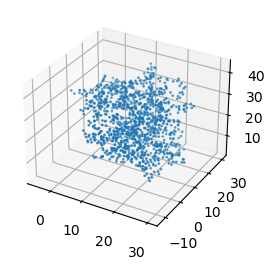

In [3]:
structure = extract_structure(r"refined\1ezq\1ezq_pocket.ligen.pdb")
X,atoms = extract_protein(structure)
ax = plt.figure(figsize=(3,3)).add_subplot(projection='3d')
ax.scatter(X[:,0],X[:,1],X[:,2],s=1.)

# Voxelizzazione

In [4]:
def voxelize(X, size):
    x_min,x_max = X[:,0].min(),X[:,0].max()
    y_min,y_max = X[:,1].min(),X[:,1].max()
    z_min,z_max = X[:,2].min(),X[:,2].max()
    grid = np.zeros((size,size,size))
    for x in X:
        x_pos = int((x[0] - x_min) / (x_max - x_min) * (size - 1) )
        y_pos = int((x[1] - y_min) / (y_max - y_min) * (size - 1) )
        z_pos = int((x[2] - z_min) / (z_max - z_min) * (size - 1) )
        grid[x_pos,y_pos,z_pos] = 1.
    return grid
griglia = voxelize(X,32)

In [5]:
def get_voxel_from_pdb(filename,size = 32):
    structure = extract_structure(filename)
    X,atoms = extract_protein(structure)
    return voxelize(X,size)

# Inizializzo le griglie

In [6]:
grids = []

In [7]:
import os
refined_folder = 'refined'
count = 0
for root, dirnames, filenames in os.walk(refined_folder):
        for filename in filenames:
            if filename.endswith(('_pocket.pdb')):
                whole_path = '%s\\%s' % (root,filename)
                grids.append(get_voxel_from_pdb(whole_path))
                print("%s done" % whole_path)
            count +=1 
        if count > 1000:
            break

refined\1a1e\1a1e_pocket.pdb done
refined\1a28\1a28_pocket.pdb done
refined\1a30\1a30_pocket.pdb done
refined\1a4k\1a4k_pocket.pdb done
refined\1a4r\1a4r_pocket.pdb done
refined\1a4w\1a4w_pocket.pdb done
refined\1a69\1a69_pocket.pdb done
refined\1a94\1a94_pocket.pdb done
refined\1a99\1a99_pocket.pdb done
refined\1a9m\1a9m_pocket.pdb done
refined\1a9q\1a9q_pocket.pdb done
refined\1aaq\1aaq_pocket.pdb done
refined\1add\1add_pocket.pdb done
refined\1adl\1adl_pocket.pdb done
refined\1ado\1ado_pocket.pdb done
refined\1afk\1afk_pocket.pdb done
refined\1afl\1afl_pocket.pdb done
refined\1ai4\1ai4_pocket.pdb done
refined\1ai5\1ai5_pocket.pdb done
refined\1ai7\1ai7_pocket.pdb done
refined\1aid\1aid_pocket.pdb done
refined\1aj7\1aj7_pocket.pdb done
refined\1ajn\1ajn_pocket.pdb done
refined\1ajp\1ajp_pocket.pdb done
refined\1ajq\1ajq_pocket.pdb done
refined\1ajv\1ajv_pocket.pdb done
refined\1ajx\1ajx_pocket.pdb done
refined\1alw\1alw_pocket.pdb done
refined\1amk\1amk_pocket.pdb done
refined\1amw\1

C:\Users\Luca\AppData\Local\Temp\ipykernel_2664\2723194693.py:5: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


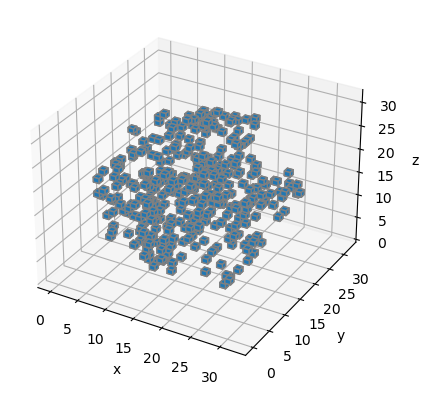

In [8]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
def make_ax(grid=False):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.grid(grid)
    return ax

filled = grids[10]

ax = make_ax(True)
ax.voxels(filled, edgecolors='gray', shade=False)
plt.show()

# Autoencoder - Data ingestion

In [9]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt # plotting library
import random 
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms

torch.cuda.is_available()

True

In [10]:
if torch.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu"  
device = torch.device(dev)
torch.set_default_device(device) 
device

device(type='cuda', index=0)

In [258]:
data_dir = 'dataset'

train_dataset = grids

train_dataset = [
        torch.tensor(g[None,:].astype(np.float32))
    for g in grids
]


m= len(train_dataset)

train_data, val_data = random_split(train_dataset, [int(m-m*0.2), m - int(m-m*0.2)],torch.Generator(device='cuda'))
batch_size=30



train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,generator = torch.Generator(device='cuda'))
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size,generator = torch.Generator(device='cuda'))

# Autoencoder - Topology

In [259]:
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv3d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv3d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm3d(16),
            nn.ReLU(True),
            nn.Conv3d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
### Linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 3 * 32, 128),
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim)
        )
        
    def forward(self, x):
        #print(x.shape)
        x = self.encoder_cnn(x)
        #print(x.shape)
        x = self.flatten(x)
        #print(x.shape)
        x = self.encoder_lin(x)
        #print(x.shape)
        return x
class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 3 * 32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, 
        unflattened_size=(32, 3, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose3d(32, 16, 3, 
            stride=2, output_padding=0),
            nn.BatchNorm3d(16),
            nn.ReLU(True),
            nn.ConvTranspose3d(16, 8, 3, stride=2, 
            padding=0, output_padding=0),
            nn.BatchNorm3d(8),
            nn.ReLU(True),
            nn.ConvTranspose3d(8, 1, 4, stride=2, 
            padding=0, output_padding=0)
        )
        
    def forward(self, x):
        #print(x.shape)
        x = self.decoder_lin(x)
        #print(x.shape)
        x = self.unflatten(x)
        #print(x.shape)
        x = self.decoder_conv(x)
        #print(x.shape)
        x = torch.sigmoid(x)
        return x

In [292]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001

### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
d = 128

#model = Autoencoder(encoded_space_dim=encoded_space_dim)
encoder = Encoder(encoded_space_dim=d,fc2_input_dim=128)
decoder = Decoder(encoded_space_dim=d,fc2_input_dim=128)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

Selected device: cuda


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=864, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose3d(32, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2))
    (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose3d(16, 8, kernel_size=(3, 3, 3), stride=(2, 2, 2))
    (4): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose3d(8, 1, kernel_size=(4, 4, 4), stride=(2, 2, 2))
  )
)

In [293]:
print(encoder)

Encoder(
  (encoder_cnn): Sequential(
    (0): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    (1): ReLU(inplace=True)
    (2): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    (3): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
    (5): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2))
    (6): ReLU(inplace=True)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (encoder_lin): Sequential(
    (0): Linear(in_features=864, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=128, bias=True)
  )
)


In [294]:
### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        # Encode data
        encoded_data = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

In [295]:
### Testing function
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [296]:
torch.autograd.set_detect_anomaly(True)
num_epochs = 500
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
   print("!")
   train_loss = train_epoch(encoder,decoder,device,train_loader,loss_fn,optim)
   val_loss   = test_epoch(encoder,decoder,device,valid_loader,loss_fn)
   print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
   diz_loss['train_loss'].append(train_loss)
   diz_loss['val_loss'].append(val_loss)

!
	 partial train loss (single batch): 0.264933
	 partial train loss (single batch): 0.258610
	 partial train loss (single batch): 0.252294
	 partial train loss (single batch): 0.246387
	 partial train loss (single batch): 0.240587

 EPOCH 1/500 	 train loss 0.25256210565567017 	 val loss 0.25450870394706726
!
	 partial train loss (single batch): 0.235077
	 partial train loss (single batch): 0.229525
	 partial train loss (single batch): 0.224176
	 partial train loss (single batch): 0.218976
	 partial train loss (single batch): 0.213589

 EPOCH 2/500 	 train loss 0.22426851093769073 	 val loss 0.24933385848999023
!
	 partial train loss (single batch): 0.208692
	 partial train loss (single batch): 0.203571
	 partial train loss (single batch): 0.198696
	 partial train loss (single batch): 0.194033
	 partial train loss (single batch): 0.188976

 EPOCH 3/500 	 train loss 0.19879356026649475 	 val loss 0.23863652348518372
!
	 partial train loss (single batch): 0.184690
	 partial train loss (

	 partial train loss (single batch): 0.024597
	 partial train loss (single batch): 0.022764

 EPOCH 27/500 	 train loss 0.024067306891083717 	 val loss 0.02611146867275238
!
	 partial train loss (single batch): 0.024204
	 partial train loss (single batch): 0.023349
	 partial train loss (single batch): 0.023372
	 partial train loss (single batch): 0.023950
	 partial train loss (single batch): 0.022120

 EPOCH 28/500 	 train loss 0.023399028927087784 	 val loss 0.025399429723620415
!
	 partial train loss (single batch): 0.023584
	 partial train loss (single batch): 0.022740
	 partial train loss (single batch): 0.022777
	 partial train loss (single batch): 0.023371
	 partial train loss (single batch): 0.021543

 EPOCH 29/500 	 train loss 0.022802989929914474 	 val loss 0.02477995678782463
!
	 partial train loss (single batch): 0.023030
	 partial train loss (single batch): 0.022192
	 partial train loss (single batch): 0.022242
	 partial train loss (single batch): 0.022850
	 partial train l

	 partial train loss (single batch): 0.017846
	 partial train loss (single batch): 0.015976

 EPOCH 54/500 	 train loss 0.017128650099039078 	 val loss 0.01905275695025921
!
	 partial train loss (single batch): 0.017672
	 partial train loss (single batch): 0.016879
	 partial train loss (single batch): 0.017021
	 partial train loss (single batch): 0.017766
	 partial train loss (single batch): 0.015896

 EPOCH 55/500 	 train loss 0.01704678311944008 	 val loss 0.018976155668497086
!
	 partial train loss (single batch): 0.017593
	 partial train loss (single batch): 0.016800
	 partial train loss (single batch): 0.016943
	 partial train loss (single batch): 0.017691
	 partial train loss (single batch): 0.015819

 EPOCH 56/500 	 train loss 0.016969352960586548 	 val loss 0.01889926753938198
!
	 partial train loss (single batch): 0.017519
	 partial train loss (single batch): 0.016726
	 partial train loss (single batch): 0.016869
	 partial train loss (single batch): 0.017620
	 partial train lo

	 partial train loss (single batch): 0.015705
	 partial train loss (single batch): 0.015842
	 partial train loss (single batch): 0.016637
	 partial train loss (single batch): 0.014733

 EPOCH 81/500 	 train loss 0.015882382169365883 	 val loss 0.017853716388344765
!
	 partial train loss (single batch): 0.016465
	 partial train loss (single batch): 0.015680
	 partial train loss (single batch): 0.015819
	 partial train loss (single batch): 0.016615
	 partial train loss (single batch): 0.014707

 EPOCH 82/500 	 train loss 0.015857180580496788 	 val loss 0.017841417342424393
!
	 partial train loss (single batch): 0.016443
	 partial train loss (single batch): 0.015658
	 partial train loss (single batch): 0.015793
	 partial train loss (single batch): 0.016593
	 partial train loss (single batch): 0.014685

 EPOCH 83/500 	 train loss 0.015834584832191467 	 val loss 0.01779094897210598
!
	 partial train loss (single batch): 0.016420
	 partial train loss (single batch): 0.015635
	 partial train 

	 partial train loss (single batch): 0.015250
	 partial train loss (single batch): 0.015370
	 partial train loss (single batch): 0.016189
	 partial train loss (single batch): 0.014258

 EPOCH 108/500 	 train loss 0.015416835434734821 	 val loss 0.01744428649544716
!
	 partial train loss (single batch): 0.016013
	 partial train loss (single batch): 0.015239
	 partial train loss (single batch): 0.015354
	 partial train loss (single batch): 0.016173
	 partial train loss (single batch): 0.014241

 EPOCH 109/500 	 train loss 0.015403973869979382 	 val loss 0.017417702823877335
!
	 partial train loss (single batch): 0.015991
	 partial train loss (single batch): 0.015229
	 partial train loss (single batch): 0.015335
	 partial train loss (single batch): 0.016159
	 partial train loss (single batch): 0.014233

 EPOCH 110/500 	 train loss 0.01538966316729784 	 val loss 0.0173881147056818
!
	 partial train loss (single batch): 0.015982
	 partial train loss (single batch): 0.015219
	 partial train 

	 partial train loss (single batch): 0.015740
	 partial train loss (single batch): 0.015005
	 partial train loss (single batch): 0.015085
	 partial train loss (single batch): 0.015931
	 partial train loss (single batch): 0.013969

 EPOCH 135/500 	 train loss 0.015145954675972462 	 val loss 0.017169786617159843
!
	 partial train loss (single batch): 0.015732
	 partial train loss (single batch): 0.015003
	 partial train loss (single batch): 0.015075
	 partial train loss (single batch): 0.015917
	 partial train loss (single batch): 0.013955

 EPOCH 136/500 	 train loss 0.015136398375034332 	 val loss 0.017204491421580315
!
	 partial train loss (single batch): 0.015729
	 partial train loss (single batch): 0.014993
	 partial train loss (single batch): 0.015074
	 partial train loss (single batch): 0.015916
	 partial train loss (single batch): 0.013948

 EPOCH 137/500 	 train loss 0.015131773427128792 	 val loss 0.01719164103269577
!
	 partial train loss (single batch): 0.015721
	 partial tra

	 partial train loss (single batch): 0.015542
	 partial train loss (single batch): 0.014854
	 partial train loss (single batch): 0.014893
	 partial train loss (single batch): 0.015753
	 partial train loss (single batch): 0.013748

 EPOCH 162/500 	 train loss 0.014958037063479424 	 val loss 0.0170208178460598
!
	 partial train loss (single batch): 0.015537
	 partial train loss (single batch): 0.014832
	 partial train loss (single batch): 0.014886
	 partial train loss (single batch): 0.015745
	 partial train loss (single batch): 0.013747

 EPOCH 163/500 	 train loss 0.014949399046599865 	 val loss 0.017045563086867332
!
	 partial train loss (single batch): 0.015528
	 partial train loss (single batch): 0.014846
	 partial train loss (single batch): 0.014878
	 partial train loss (single batch): 0.015737
	 partial train loss (single batch): 0.013730

 EPOCH 164/500 	 train loss 0.014943813905119896 	 val loss 0.017015650868415833
!
	 partial train loss (single batch): 0.015524
	 partial trai

	 partial train loss (single batch): 0.015377
	 partial train loss (single batch): 0.014692
	 partial train loss (single batch): 0.014728
	 partial train loss (single batch): 0.015600
	 partial train loss (single batch): 0.013523

 EPOCH 189/500 	 train loss 0.014783862046897411 	 val loss 0.016921391710639
!
	 partial train loss (single batch): 0.015375
	 partial train loss (single batch): 0.014691
	 partial train loss (single batch): 0.014719
	 partial train loss (single batch): 0.015601
	 partial train loss (single batch): 0.013514

 EPOCH 190/500 	 train loss 0.014779878780245781 	 val loss 0.016913780942559242
!
	 partial train loss (single batch): 0.015359
	 partial train loss (single batch): 0.014680
	 partial train loss (single batch): 0.014717
	 partial train loss (single batch): 0.015590
	 partial train loss (single batch): 0.013508

 EPOCH 191/500 	 train loss 0.01477076392620802 	 val loss 0.016960153356194496
!
	 partial train loss (single batch): 0.015363
	 partial train 

	 partial train loss (single batch): 0.015271
	 partial train loss (single batch): 0.014585
	 partial train loss (single batch): 0.014608
	 partial train loss (single batch): 0.015485
	 partial train loss (single batch): 0.013343

 EPOCH 216/500 	 train loss 0.014658275060355663 	 val loss 0.01688169687986374
!
	 partial train loss (single batch): 0.015248
	 partial train loss (single batch): 0.014579
	 partial train loss (single batch): 0.014598
	 partial train loss (single batch): 0.015504
	 partial train loss (single batch): 0.013333

 EPOCH 217/500 	 train loss 0.014652526006102562 	 val loss 0.016868753358721733
!
	 partial train loss (single batch): 0.015234
	 partial train loss (single batch): 0.014591
	 partial train loss (single batch): 0.014595
	 partial train loss (single batch): 0.015483
	 partial train loss (single batch): 0.013327

 EPOCH 218/500 	 train loss 0.014646174386143684 	 val loss 0.0168911200016737
!
	 partial train loss (single batch): 0.015224
	 partial train

	 partial train loss (single batch): 0.014481
	 partial train loss (single batch): 0.014508
	 partial train loss (single batch): 0.015413
	 partial train loss (single batch): 0.013191

 EPOCH 242/500 	 train loss 0.01454712450504303 	 val loss 0.016850605607032776
!
	 partial train loss (single batch): 0.015139
	 partial train loss (single batch): 0.014516
	 partial train loss (single batch): 0.014503
	 partial train loss (single batch): 0.015423
	 partial train loss (single batch): 0.013219

 EPOCH 243/500 	 train loss 0.01456008292734623 	 val loss 0.016836322844028473
!
	 partial train loss (single batch): 0.015133
	 partial train loss (single batch): 0.014529
	 partial train loss (single batch): 0.014517
	 partial train loss (single batch): 0.015393
	 partial train loss (single batch): 0.013203

 EPOCH 244/500 	 train loss 0.01455498207360506 	 val loss 0.016833361238241196
!
	 partial train loss (single batch): 0.015150
	 partial train loss (single batch): 0.014470
	 partial train

	 partial train loss (single batch): 0.015298
	 partial train loss (single batch): 0.013060

 EPOCH 268/500 	 train loss 0.014452253468334675 	 val loss 0.01681443862617016
!
	 partial train loss (single batch): 0.015038
	 partial train loss (single batch): 0.014389
	 partial train loss (single batch): 0.014419
	 partial train loss (single batch): 0.015299
	 partial train loss (single batch): 0.013058

 EPOCH 269/500 	 train loss 0.014440556988120079 	 val loss 0.016849130392074585
!
	 partial train loss (single batch): 0.015016
	 partial train loss (single batch): 0.014379
	 partial train loss (single batch): 0.014408
	 partial train loss (single batch): 0.015293


KeyboardInterrupt: 

# Creazione

In [298]:
import jax
import jax.numpy as jnp
sample = 39
jnp.linalg.norm(
    jnp.array(
        (decoder(encoder(train_dataset[sample][None,:,:,:]))[0,0] - train_dataset[sample]).detach().cpu()
    )
)

DeviceArray(26.366138, dtype=float32)

C:\Users\Luca\AppData\Local\Temp\ipykernel_2664\2723194693.py:5: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


KeyboardInterrupt: 

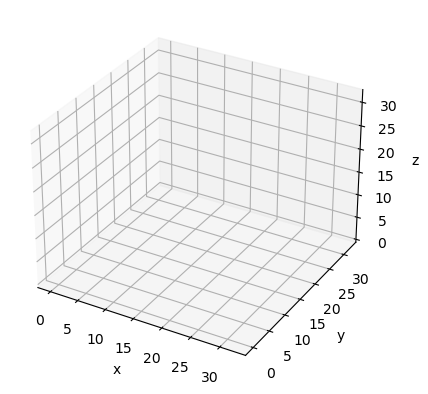

In [303]:
ax = make_ax(True)
ax.voxels(
        jnp.array(
        (decoder(encoder(train_dataset[sample][None,:,:,:]))[0,0]).detach().cpu() > 0.5
    )
    )
ax.show()